# HOMEWORK 5

In this homework you are going to implement the **Floyd-Steinberg dithering** algorithm. Dithering, in general, means that we are adding noise to the signal (in our case digital image) in order to perceive it better. In other words, by adding the noise the objective quality will be worse but the subjective quality will be better (i.e. the image will "look" better).

The details of FS dithering can be found in this [wiki](https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering) page. In order to implement the dithering, we will implement the following steps:
* Define colour pallette
* Quantize the image to obtain the baseline and compute the average quantization error
* Implement FS dithering and compute the average quantization error

You will also have to answer the question at the end of this notebook.

Note: In this homework, you will have the chance to earn some extra points. See the "Bonus" section at the end of the notebook. Good luck!

As always, you are encouraged to use your own images :-)

In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load the image.

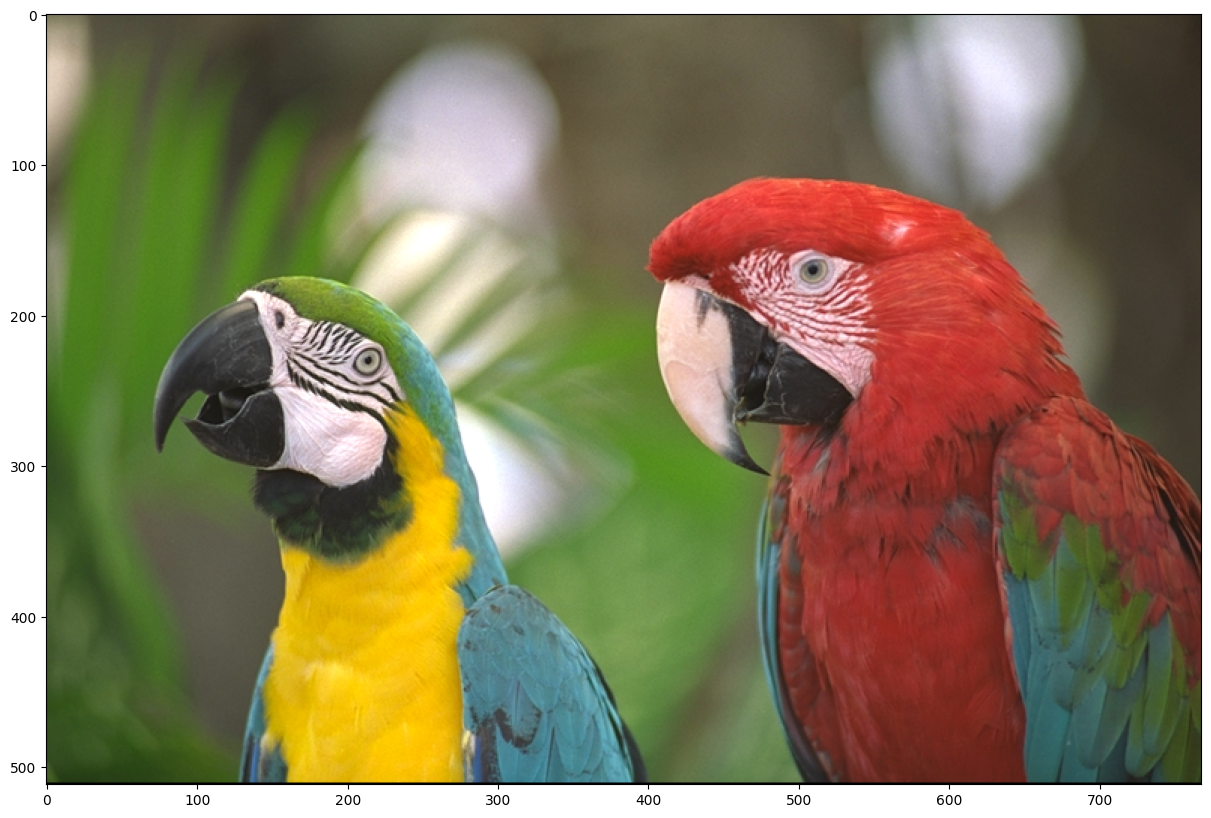

In [2]:
# Load image
img = cv2.imread('../data/kodim23.png')
# Convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Plot it
plt.imshow(img)

Let's start with gray tones first.

In [3]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0],
                   [64, 64, 64],
                   [192, 192, 192],
                   [255, 255, 255]])

Using the colour pallette, let's quantize the original image.

In [4]:
def find_closest_color(pixel, colors):
    closest_pixel = closest_pixel_distance = None
    for color in colors:
        distance = np.linalg.norm(pixel - color)
        if closest_pixel is None:
            closest_pixel = color
            closest_pixel_distance = distance
        elif distance < closest_pixel_distance:
            closest_pixel = color
            closest_pixel_distance = distance
    return closest_pixel

In [5]:
def quantize(img, colors):
    # Prepare for quantization
    rows, cols, channels = img.shape
    quantized = np.zeros_like(img)
    
    # Apply quantization
    for r in range(rows):
        for c in range(cols):
            # Extract the original pixel value
            pixel = img[r,c]
            
            # Find the closest colour from the pallette (using absolute value/Euclidean distance)
            new_pixel = find_closest_color(pixel, colors)
            
            # Apply quantization
            quantized[r, c, :] = new_pixel
    return quantized

In [6]:
# Cast the image to float
img = img.astype(np.float64)

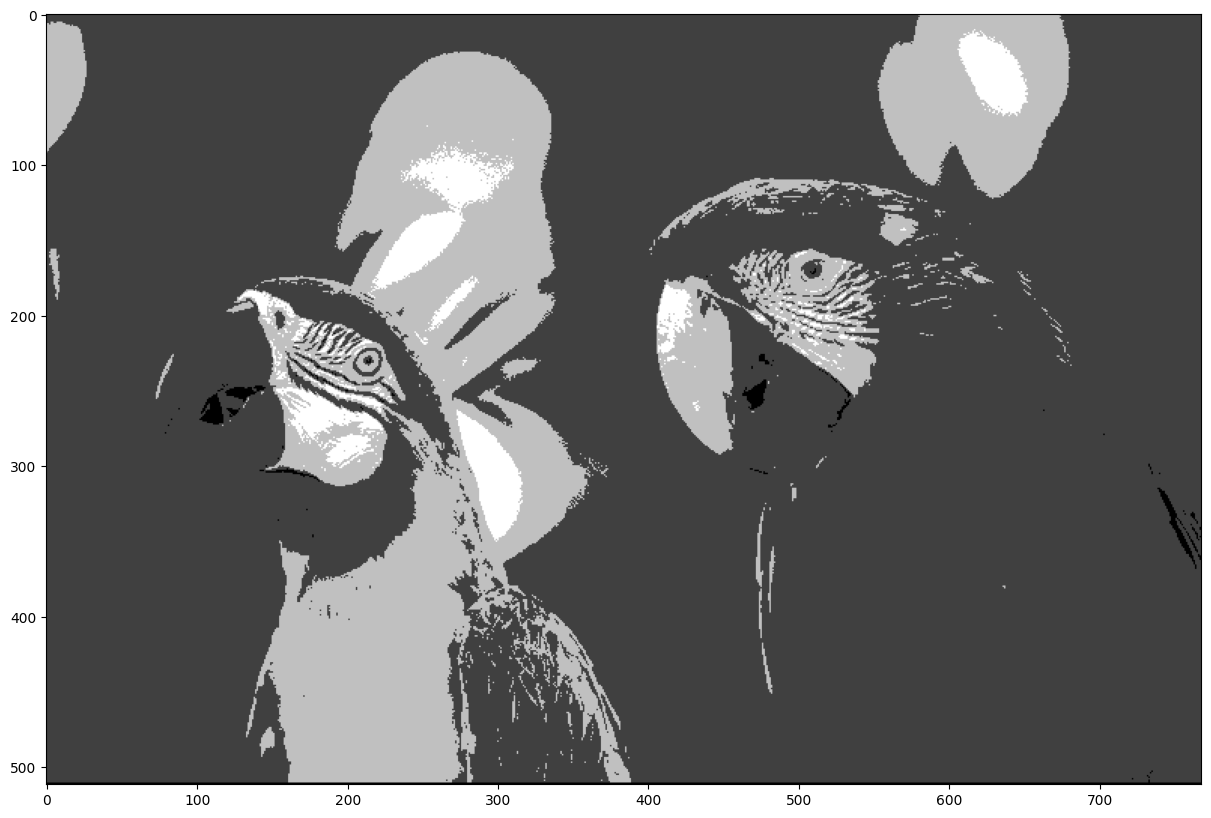

In [7]:
quantized = quantize(img, colors)
# Show quantized image (don't forget to cast back to uint8)
plt.imshow(quantized.astype(np.uint8))

In [8]:
def psnr(original, transformed):
    mse = np.mean(np.square(original - transformed))
    return 20 * np.log10(255 / (np.sqrt(mse)))

In [9]:
# Compute average quantization error
avg_quant_error = psnr(img, quantized)
print(avg_quant_error)

14.826061547883146


#### Floyd-Steinberg Dithering
We are now going to implement the FS dithering and compare it to the optimally quantized image we have calculated above.

In [10]:
def dithering(img, colors):
    # Make a temporal copy of the original image, we will need it for error diffusion
    img_tmp = np.copy(img)
    dithered = np.zeros_like(img)

    rows, cols, channels = img.shape
    for r in range(1, rows-1):
        for c in range(1, cols-1):
            # Extract the original pixel value
            pixel = img_tmp[r, c]
            
            # Find the closest colour from the pallette (using absolute value/Euclidean distance)
            new_pixel = find_closest_color(pixel, colors)
            
            # Compute quantization error
            quant_error = pixel - new_pixel
            
            # Diffuse the quantization error accroding to the FS diffusion matrix
            img_tmp[r, c + 1, :] += quant_error * 7/16
            img_tmp[r + 1, c - 1, :] += quant_error * 3/16
            img_tmp[r + 1, c, :] += quant_error * 5/16
            img_tmp[r + 1, c + 1, :] += quant_error * 1/16
            
            # Apply dithering
            dithered[r, c, :] = new_pixel
    return dithered

In [11]:
dithered = dithering(img, colors)

(<Axes: >, <matplotlib.image.AxesImage at 0x7f737efb2180>)

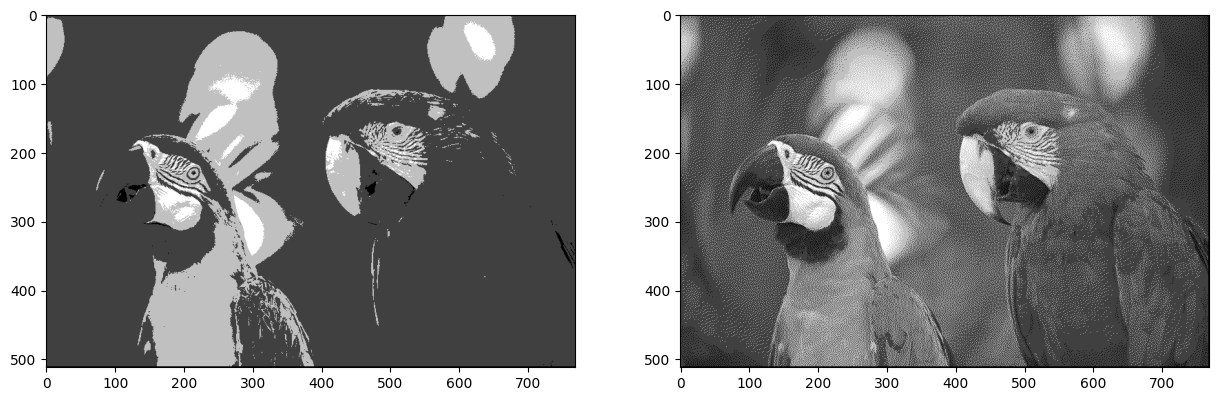

In [12]:
# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow(quantized.astype(np.uint8))   # optimally quantized
plt.subplot(122), plt.imshow(dithered.astype(np.uint8))   # dithering

In [13]:
# Compute average quantization error for dithered image
avg_dith_error = psnr(img, dithered)
print(avg_dith_error)

12.94152076732435


### Questions
* Which image has higher quantization error? Optimally quantized or dithered?

  Dithered has higher error
* Which image looks better to you?

  Dithered
* Can you repeat the same process using only two colours: black and white? Show me :-)

(<Axes: >, <matplotlib.image.AxesImage at 0x7f737e5871d0>)

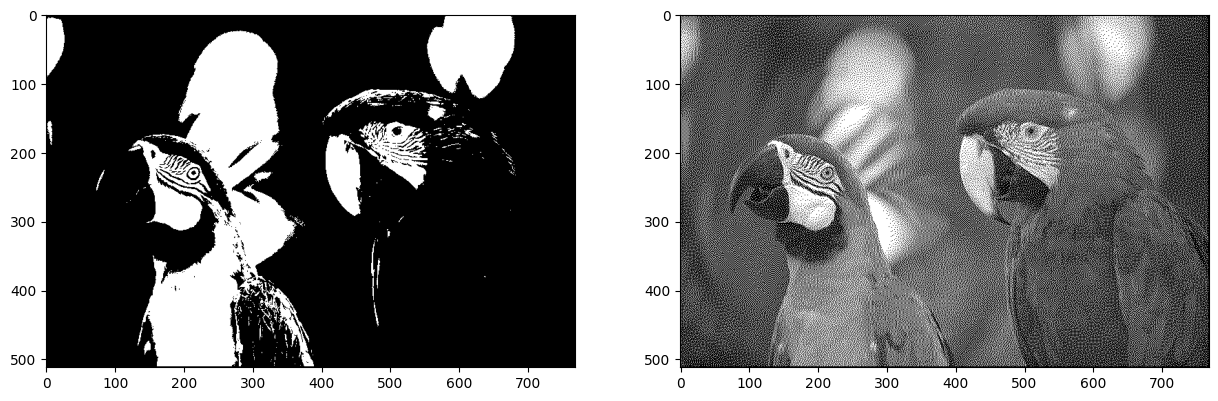

In [14]:
colors = np.array([[0, 0, 0],
                   [255, 255, 255]])

quantized = quantize(img, colors)
dithered = dithering(img, colors)

plt.subplot(121), plt.imshow(quantized.astype(np.uint8))
plt.subplot(122), plt.imshow(dithered.astype(np.uint8))  

In [15]:
print("Dithered PSNR: " + str(psnr(img, dithered)))
print('Quantized PSNR: ' + str(psnr(img, quantized)))

Dithered PSNR: 6.4434351247085075
Quantized PSNR: 8.787832707162266


### Bonus Points

Repeat the homework using a diffrerent image pallette. For instance, you can use an optimal colour
pallette that we can calculate via k-means algorithm. The following snippet of code will give you the 16
optimal colours for your original image.

In [16]:
from sklearn.cluster import KMeans

Dithered PSNR: 16.954346944733206
Quantized PSNR: 17.113479821919828


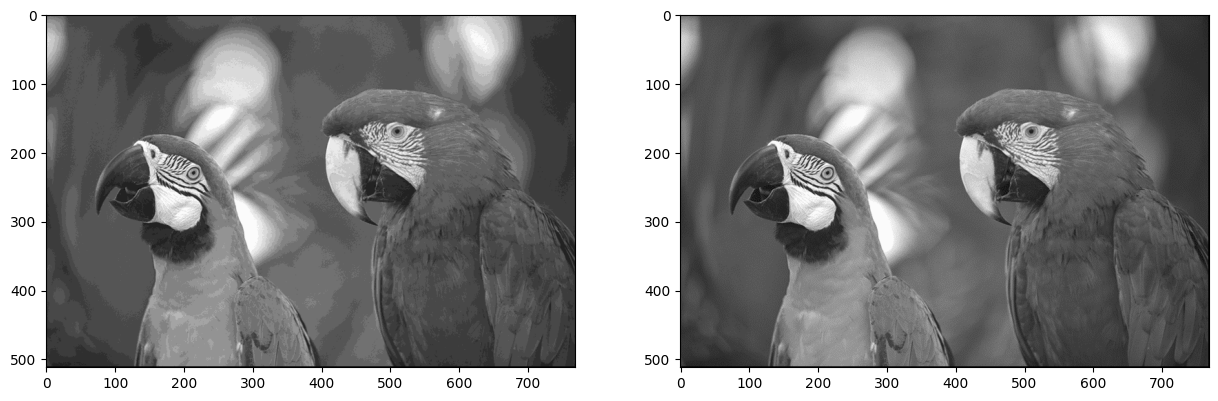

In [17]:
kmeans = KMeans(n_clusters=16).fit(np.reshape(img, (-1, 1)))
colors = kmeans.cluster_centers_
quantized = quantize(img, colors)
dithered = dithering(img, colors)

plt.subplot(121), plt.imshow(quantized.astype(np.uint8))
plt.subplot(122), plt.imshow(dithered.astype(np.uint8))  
print("Dithered PSNR: " + str(psnr(img, dithered)))
print('Quantized PSNR: ' + str(psnr(img, quantized)))

Dithered PSNR: 17.0235274097082
Quantized PSNR: 17.157452487077855


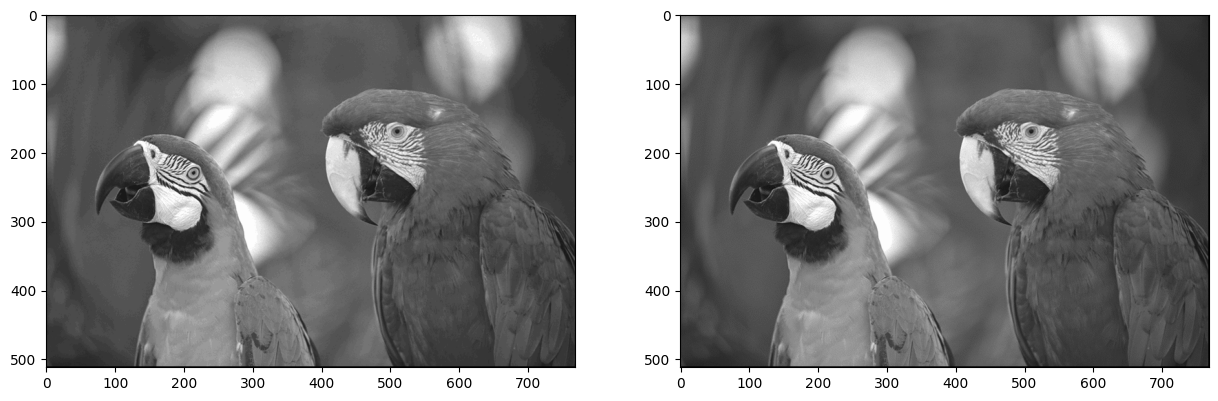

In [18]:
kmeans = KMeans(n_clusters=32).fit(np.reshape(img, (-1, 1)))
colors = kmeans.cluster_centers_
quantized = quantize(img, colors)
dithered = dithering(img, colors)

plt.subplot(121), plt.imshow(quantized.astype(np.uint8))
plt.subplot(122), plt.imshow(dithered.astype(np.uint8))  
print("Dithered PSNR: " + str(psnr(img, dithered)))
print('Quantized PSNR: ' + str(psnr(img, quantized)))

Dithered PSNR: 17.04557955576238
Quantized PSNR: 17.173662780696716


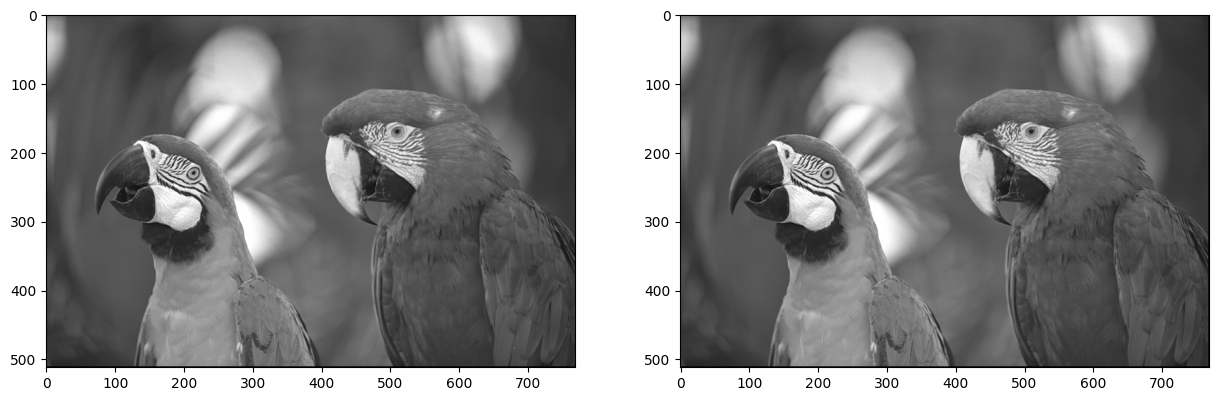

In [19]:
kmeans = KMeans(n_clusters=256).fit(np.reshape(img, (-1, 1)))
colors = kmeans.cluster_centers_
quantized = quantize(img, colors)
dithered = dithering(img, colors)

plt.subplot(121), plt.imshow(quantized.astype(np.uint8))
plt.subplot(122), plt.imshow(dithered.astype(np.uint8))  
print("Dithered PSNR: " + str(psnr(img, dithered)))
print('Quantized PSNR: ' + str(psnr(img, quantized)))

Apply FS dithering the same way you did before.
* How does the result look like to you?

  Quantized is much better. Dithered has less noises.
* What happens if we use 32 colours?
* And what happens if we use 256 colours?

Dithered PSNR: 7.049001075972544
Quantized PSNR: 9.777393846281656


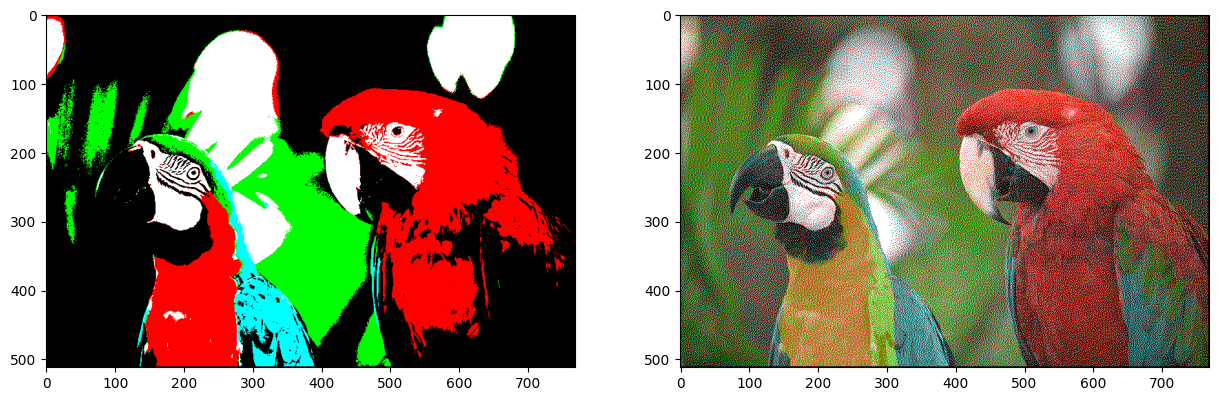

In [20]:
# Just for fun
colors = colors = np.array([[0, 0, 0],
                   [255, 0, 0],
                   [0, 255, 0],
                   [0, 255, 255],         
                   [255, 255, 255]])
quantized = quantize(img, colors)
dithered = dithering(img, colors)

plt.subplot(121), plt.imshow(quantized.astype(np.uint8))
plt.subplot(122), plt.imshow(dithered.astype(np.uint8))  
print("Dithered PSNR: " + str(psnr(img, dithered)))
print('Quantized PSNR: ' + str(psnr(img, quantized)))